<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Training-a-second-model" data-toc-modified-id="Training-a-second-model-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Training a second model</a></span></li><li><span><a href="#Validating-that-features-are-useful" data-toc-modified-id="Validating-that-features-are-useful-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Validating that features are useful</a></span></li><li><span><a href="#Comparing-predictions-to-data" data-toc-modified-id="Comparing-predictions-to-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Comparing predictions to data</a></span></li><li><span><a href="#Inference-Function" data-toc-modified-id="Inference-Function-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Inference Function</a></span></li></ul></div>

# Training a second model

In this notebook, train a second model using features in order to address the first model's shortcomings.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
# import joblib
from sklearn.externals import joblib

import sys
sys.path.append('..')
import warnings
warnings.filterwarnings('ignore')

In [2]:
from ml_editor.ch4_data_processing import (format_raw_df, get_split_by_author,
                                           train_vectorizer,
                                           get_vectorized_series,
                                           get_feature_vector_and_label)

In [3]:
from ml_editor.ch5_model_evaluation import (get_feature_importance,
                                            get_roc_plot,
                                            get_confusion_matrix_plot,
                                            get_calibration_plot)

In [5]:
from ml_editor.ch7_model_v2 import (add_char_count_features, get_word_stats,
                                    get_sentiment_score, POS_NAMES,
                                    get_question_score_from_input)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Vidya\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [7]:
%load_ext autoreload
%autoreload 2
np.random.seed(35)

In [8]:
data_path = Path('../raw_data/writers.csv')
df = pd.read_csv(data_path)
df = format_raw_df(df.copy())
df = df.loc[df['is_question']].copy()

In [9]:
df['full_text'] = df['Title'].str.cat(df['body_text'], sep=' ', na_rep='')

Let's add new features we've identified as potential candidates in our new model.

In [10]:
train_df, test_df = get_split_by_author(df, test_size=0.2, random_state=40)

In [11]:
vectorizer = train_vectorizer(train_df)
df['vectors'] = get_vectorized_series(df['full_text'].copy(), vectorizer)

In [13]:
# Check out the ml_editor source code to see more about what these functions are doing!

df = add_char_count_features(df.copy())
df = get_word_stats(df.copy())
df = get_sentiment_score(df.copy())

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Vidya\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
100%|███████████████████████████████████████████████████████████████████████████| 10255/10255 [00:15<00:00, 656.67it/s]


In [14]:
feature_arr = [
    'num_questions', 'num_periods', 'num_commas', 'num_exclam', 'num_quotes',
    'num_colon', 'num_stops', 'num_semicolon', 'num_words', 'num_chars',
    'num_diff_words', 'avg_word_len', 'polarity'
]
feature_arr.extend(POS_NAMES.keys())

Now that we've added new features, let's train a new model. We'll use the same model as before, only the features are different.

In [15]:
# We split again since we have now added all features.
train_df, test_df = get_split_by_author(df, test_size=0.2, random_state=40)

In [16]:
X_train, y_train = get_feature_vector_and_label(train_df, feature_arr)
X_test, y_test = get_feature_vector_and_label(test_df, feature_arr)

In [17]:
y_train.value_counts()

False    4594
True     3761
Name: Score, dtype: int64

In [18]:
X_test.shape

(1900, 9058)

In [19]:
clf = RandomForestClassifier(n_estimators=100,
                             class_weight='balanced',
                             oob_score=True)
clf.fit(X_train, y_train)

y_predicted = clf.predict(X_test)
y_predicted_proba = clf.predict_proba(X_test)

Now, we can measure performance as we saw in the first training notebook.

In [22]:
def get_metrics(y_test, y_predicted):
    # true positives / (true positives+false positives)
    precision = precision_score(y_test,
                                y_predicted,
                                pos_label=True,
                                average='binary')

    # true positives / (true positives + false negatives)
    recall = recall_score(y_test,
                          y_predicted,
                          pos_label=True,
                          average='binary')

    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=True, average='binary')

    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1


# Training accuracy
# Thanks to https://datascience.stackexchange.com/questions/13151/randomforestclassifier-oob-scoring-method
y_train_pred = np.argmax(clf.oob_decision_function_, axis=1)
accuracy, precision, recall, f1 = get_metrics(y_train, y_train_pred)

print('Training accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f' %
      (accuracy, precision, recall, f1))

Training accuracy = 0.600, precision = 0.574, recall = 0.437, f1 = 0.496


In [23]:
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted)
print(
    'Validation accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f' %
    (accuracy, precision, recall, f1))

Validation accuracy = 0.610, precision = 0.596, recall = 0.464, f1 = 0.522


Fortunately, this model shows stronger aggregate performance than our previous model! Let's save our new model and vectorizer to disk so we can use them later.

In [24]:
model_path = Path("../models/model_2.pkl")
vectorizer_path = Path("../models/vectorizer_2.pkl")
joblib.dump(clf, model_path)
joblib.dump(vectorizer, vectorizer_path)

['..\\models\\vectorizer_2.pkl']

# Validating that features are useful

Next, we'll use the method described in the [feature importance notebook](ch_5_4_feature_importance.ipynb
) to validate that our new features are being used by the new model.


In [25]:
w_indices = vectorizer.get_feature_names()
w_indices.extend(feature_arr)
all_feature_names = np.array(w_indices)

In [27]:
k = 20
print('Top %s importances \n ' % k)
print('\n'.join([
    '%s: %.2g' % (tup[0], tup[1])
    for tup in get_feature_importance(clf, all_feature_names)[:k]
]))

Top 20 importances 
 
num_chars: 0.008
num_diff_words: 0.0073
num_periods: 0.0072
num_commas: 0.0066
ADJ: 0.0066
PUNCT: 0.0065
num_words: 0.0065
ADV: 0.0063
NOUN: 0.0063
num_questions: 0.0062
SCONJ: 0.0062
AUX: 0.006
ADP: 0.006
DET: 0.006
VERB: 0.0057
num_stops: 0.0056
polarity: 0.0055
avg_word_len: 0.0055
PART: 0.0054
PRON: 0.0054


In [28]:
print('Bottom %s importances \n ' % k)
print('\n'.join([
    '%s: %.2g' % (tup[0], tup[1])
    for tup in get_feature_importance(clf, all_feature_names)[-k:]
]))

Bottom 20 importances 
 
newest: 0
oftentimes: 0
obsession: 0
offense: 0
offending: 0
odt: 0
odds: 0
occurrences: 0
candidates: 0
occasion: 0
canvas: 0
nightmares: 0
capabilities: 0
capability: 0
obscured: 0
noting: 0
nobleman: 0
nihilistic: 0
nihilist: 0
kindness: 0


Our new features are amongst the most predictive! On the flip side, we can see that the word vectors from the TF-IDF vectorization approach don't seem to be particularly helpful. In a [following notebook](ch_7_2_third_model), we will train a third model without these features and see how well it performs.

# Comparing predictions to data

This section uses the evaluation methods described in the [Comparing Data To Predictions notebook](ch_5_2_comparing_data_to_predictions), but on our new model.

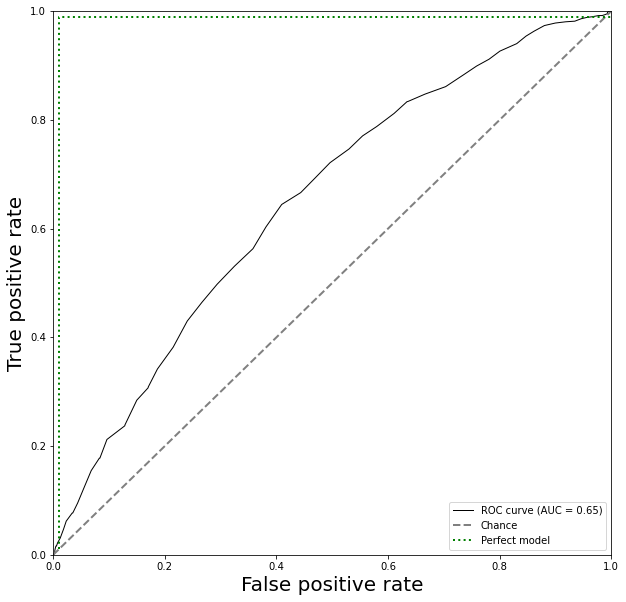

In [29]:
get_roc_plot(y_predicted_proba[:, 1], y_test, figsize=(10, 10))

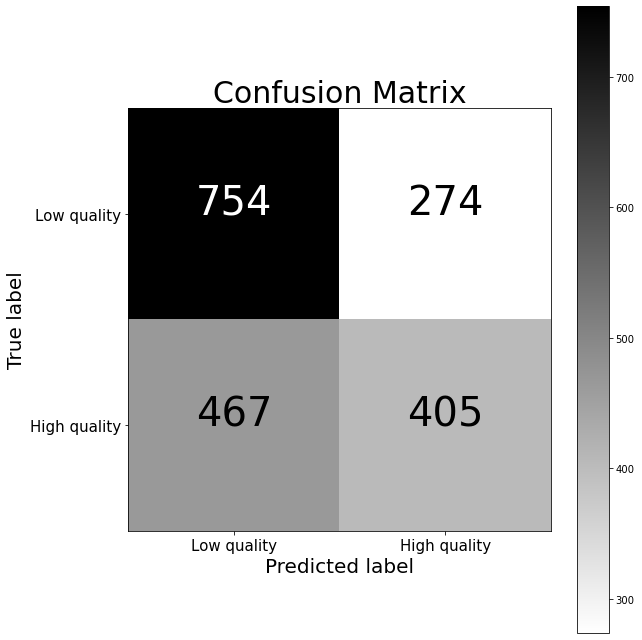

In [30]:
get_confusion_matrix_plot(y_predicted, y_test, figsize=(9, 9))

No handles with labels found to put in legend.


	Brier: 0.232 


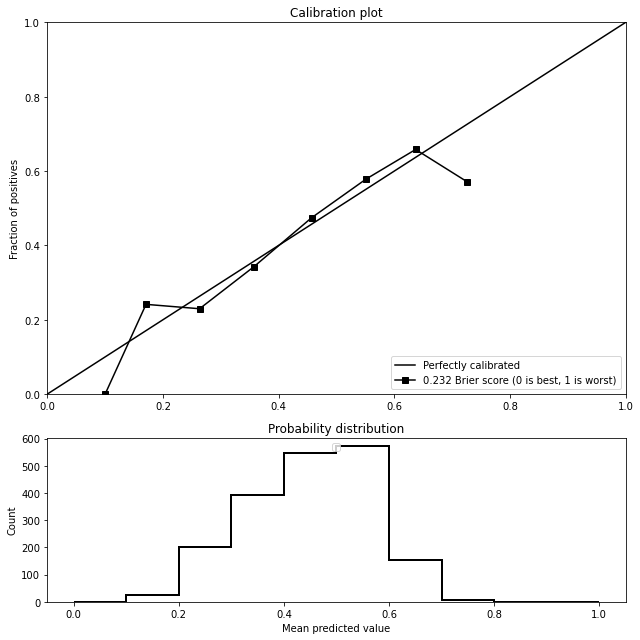

In [31]:
get_calibration_plot(y_predicted_proba[:, 1], y_test, figsize=(9, 9))

# Inference Function
Just like for our first model, we define an inference function that takes in an arbitrary question and outputs an estimated probability of it receiving a high score according to our model.

In [32]:
pos_prob = get_question_score_from_input('''
When quoting a person's informal speech, how much liberty do you have to make changes to what they say?
''')

print(
    '%s probability of the question receiving a high score according to our model'
    % (pos_prob))

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 504.91it/s]

0.39 probability of the question receiving a high score according to our model
